In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import Slider, RadioButtons
import geopandas as gpd
from shapely.geometry import Point

In [7]:
#Selecting Countries From Dataframe
covid_data = pd.read_csv('owid-covid-data-copy.csv')
selected_countries = ['United States', 'Sweden', 'Canada', 'Mexico', 'Brazil', 'Japan']
selected_data = covid_data[covid_data['location'].isin(selected_countries)]

In [8]:
selected_data = selected_data.loc[selected_data['new_cases'].notna()] #Removing NaN in new_cases

In [9]:
selected_data['date'] = pd.to_datetime(selected_data['date'])
selected_data.sort_values(['location', 'date'], inplace=True) #sorting so location and time are next to each other
#new cases per million
selected_data['new_cases_per_million'] = selected_data['new_cases'] / (selected_data['population'] / 1e6)
#calculating the 7_day average
#rolling: window sets the 7 day window and min_periods=1 means that if there is less than 7 days left it will still calculate the last value
#reset_index used to make sure rolling average is set same for 7 days then changing in df
selected_data['7_day_avg_new_cases'] = selected_data.groupby('location')['new_cases_per_million'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)

#new table with only relevant cols
my_data = pd.DataFrame({'location': selected_data['location'], 'date': selected_data['date'], '7_day_avg_new_cases': selected_data['7_day_avg_new_cases'], 'new_cases': selected_data['new_cases']})

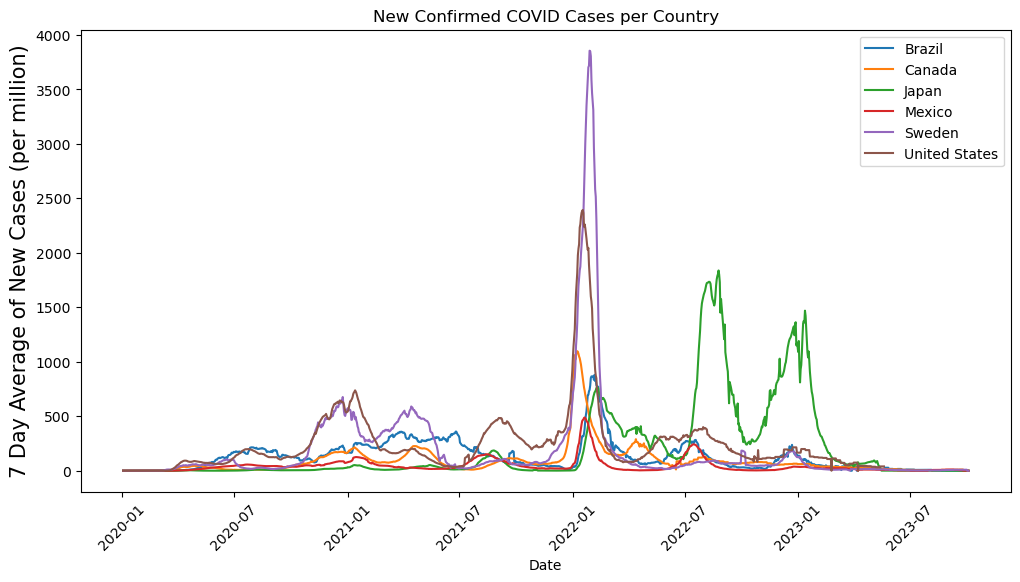

In [12]:
#chart of new confirmed COVID cases per country
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('7 Day Average of New Cases (per million)', fontsize=15)
plt.title('New Confirmed COVID Cases per Country')

sns.lineplot(x='date', y='7_day_avg_new_cases', hue='location', data=my_data)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [13]:
#Creating Data Structures for Each Date
map_data = covid_data.loc[covid_data['location'].notna()] #Removing NaN in location
map_data = map_data.loc[map_data['new_cases'].notna()] #Removing NaN in new_cases
map_data = map_data.loc[map_data['iso_code'].notna()] #Removing NaN in iso_code 
map_data['date'] = pd.to_datetime(map_data['date'])
sept_map_data = map_data[map_data['date']== '2023-09-30'] #selecting data for sept 2023
old_map_data = map_data[map_data['date']== '2020-09-30'] #selecting 

In [14]:
#Getting world map geometry and then joining to covid data by iso_code
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
old_world = old_map_data.merge(world, left_on='iso_code', right_on = 'iso_a3', how='left')
sept_world = sept_map_data.merge(world, left_on='iso_code', right_on = 'iso_a3', how='left')

#adding cases per million
old_world['new_cases_per_million'] = old_world['new_cases'] / (old_world['population'] / 1e6)
sept_world['new_cases_per_million'] = sept_world['new_cases'] / (sept_world['population'] / 1e6)

/var/folders/zn/sq9blqzd62v88bwz8xsjpqdr0000gn/T/ipykernel_36848/3205738237.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [15]:
#Extracting US geometry since it is not in sept_world data
us_geometry = old_world.loc[old_world['iso_code'] == "USA", 'geometry'].values[0]

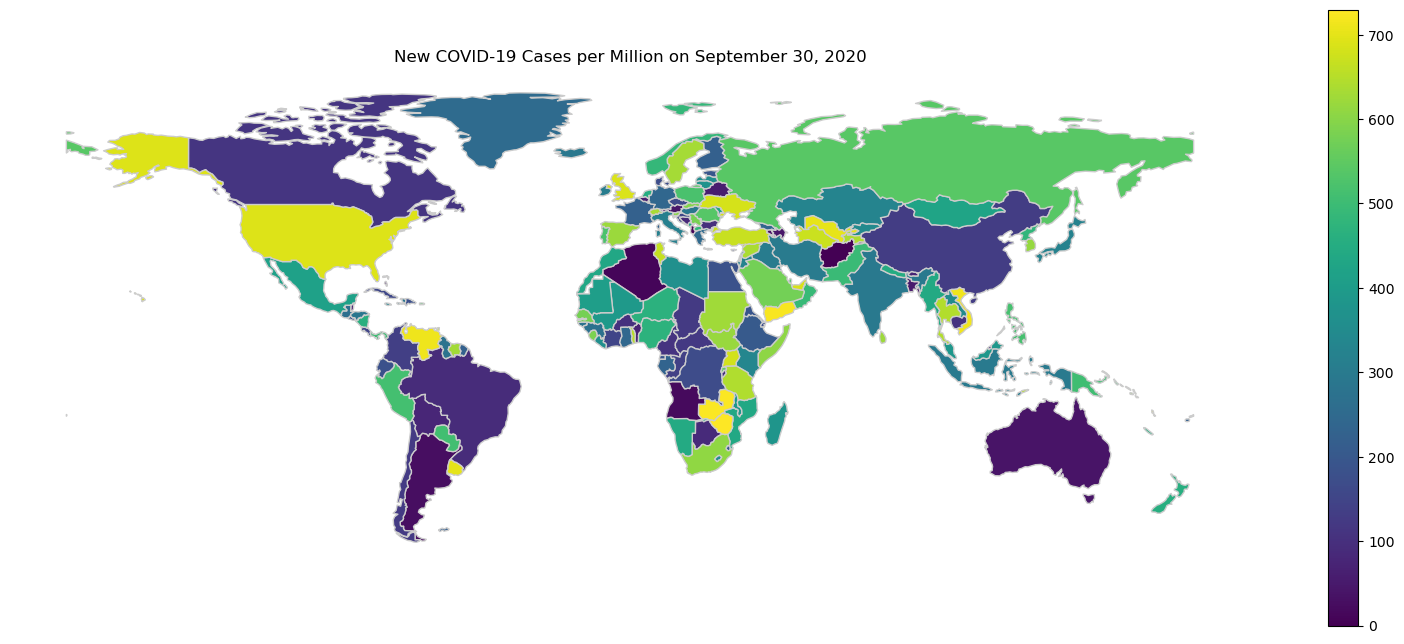

In [16]:
#September 30, 2020 Global Heatmap
old_gdf = gpd.GeoDataFrame(old_world, geometry='geometry')

old_gdf.to_file('old_output.geojson', driver='GeoJSON')
geo_old = gpd.read_file('old_output.geojson')

cmap = 'viridis'
vmin = geo_old['new_cases_per_million'].min()
vmax = geo_old['new_cases_per_million'].max()

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off') # Remove the axis

geo_old.plot(ax=ax, edgecolor = '0.8', linewidth=1, cmap = cmap)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

cbar = fig.colorbar(sm, ax=ax)

plt.title('New COVID-19 Cases per Million on September 30, 2020')
plt.show()

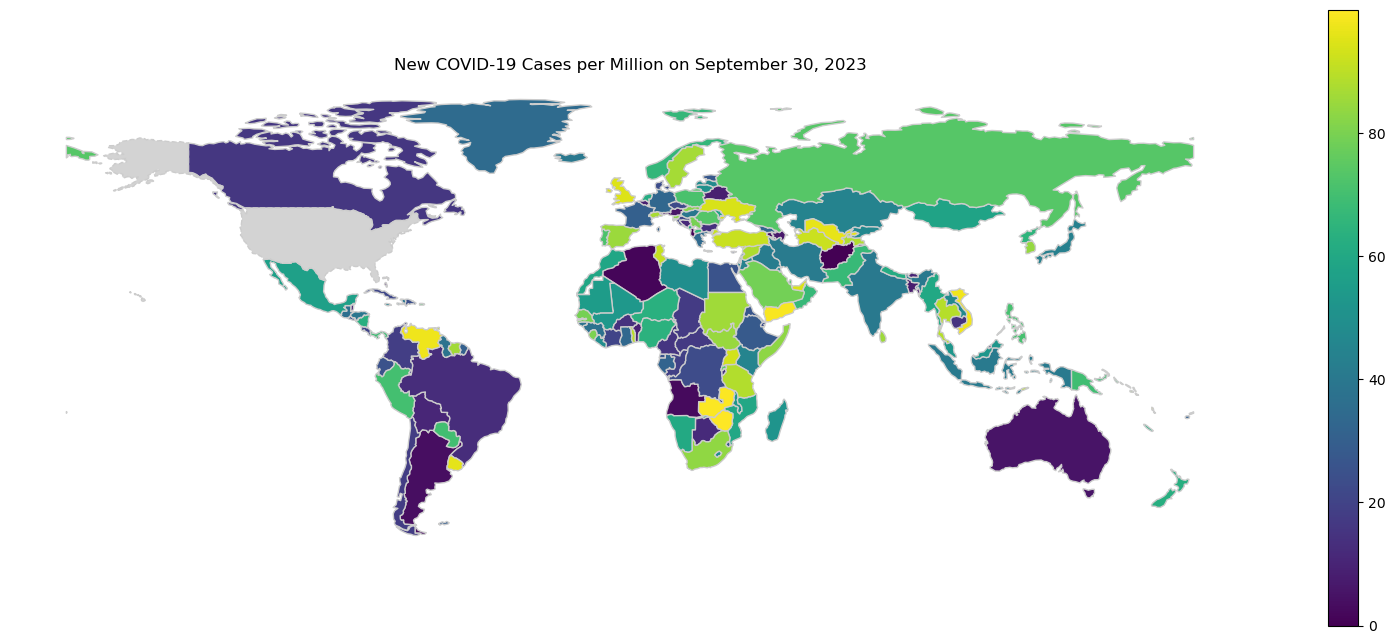

In [17]:
#September 30, 2023 Global Heatmap
sept_gdf = gpd.GeoDataFrame(sept_world, geometry='geometry')
us_gdf = gpd.GeoDataFrame(geometry=[us_geometry]) #making US geometry its own geo object

sept_gdf.to_file('sept_output.geojson', driver='GeoJSON')
geo_sept = gpd.read_file('sept_output.geojson')

cmap = 'viridis'
vmin = geo_sept['new_cases_per_million'].min()
vmax = geo_sept['new_cases_per_million'].max()

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off') # Remove the axis

geo_sept.plot(ax=ax, edgecolor = '0.8', linewidth=1, cmap = cmap)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

cbar = fig.colorbar(sm, ax=ax)

plt.title('New COVID-19 Cases per Million on September 30, 2023')

us_gdf.plot(ax=ax, edgecolor='0.8', linewidth=1, color='lightgrey', linestyle='dashed') 
#usa data not included so have to manually map it on

plt.show()